In [99]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings as w 
w.filterwarnings('ignore')
sns.set(style='whitegrid')  


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC, SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier , AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier

In [5]:
class INGESTION:
    def __init__(self):
        pass
    def ingestion(self, df_path: pd.DataFrame):
        df = pd.read_csv(df_path, sep=';')
        df['y']= df['y'].map({'yes': 1, 'no': 0})
        
        train, test = train_test_split(df, random_state=42, test_size=0.2, stratify=df['y'])

        return train, test


In [112]:
class TRANSFORMATION:
    def __init__(self):
        pass
        
    def preprocessing(self, train_data):
        num_cols= train_data.select_dtypes(include=['number']).columns.tolist()
        cat_cols= train_data.select_dtypes(include=['object']).columns.tolist()
        num_pipe= Pipeline([('impute', SimpleImputer(strategy='mean')),
                            ('scaler', StandardScaler())])

        cat_pipe= Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                            ('encoder', OneHotEncoder(drop= 'first', handle_unknown='ignore', sparse_output=False))])
        preprocessing = ColumnTransformer([('num', num_pipe, num_cols),
                                        ('cat', cat_pipe, cat_cols)])
        return preprocessing
    
    def transformation(self, train_df, test_df):
        '''train_df= pd.read_csv(train)
        test_df= pd.read_csv(test)'''
        train_X = train_df.drop('y', axis=1)
        train_y = train_df['y']

        test_X = test_df.drop('y', axis=1)
        test_y = test_df['y']

        cat_col = train_X.select_dtypes(include=['object']).columns.tolist()
        cat_idx = [train_X.columns.get_loc(col) for col in cat_col]
        smotenc = SMOTENC(categorical_features=cat_idx, sampling_strategy='minority', random_state=42)

        X_resampled, y_resampled = smotenc.fit_resample(train_X, train_y)

        preprocessor_obj = self.preprocessing(train_X)

        X_train_scaled= preprocessor_obj.fit_transform(X_resampled)
        X_test_scaled = preprocessor_obj.transform(test_X)

        train_arr= np.c_[X_train_scaled, y_resampled]
        test_arr= np.c_[X_test_scaled, test_y]
        

        return train_arr, test_arr


In [113]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

class MODEL_TRAINER:
    def __init__(self, resampling_strategy='smote'):
        self.resampling_strategy = resampling_strategy 

    def trainer(self, train_arr, test_arr):
        X_train, y_train = train_arr[:, :-1], train_arr[:, -1]
        X_test, y_test = test_arr[:, :-1], test_arr[:, -1]
        xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))
        hgb = HistGradientBoostingClassifier(class_weight='balanced')
        if self.resampling_strategy == 'smote':
            resampler = SMOTE(random_state=42)
        else:
            resampler = None
        estimators = [
            ('xgb', xgb),
            ('hgb', hgb)
        ]
        final_estimator = LogisticRegression(class_weight='balanced')

        if resampler:
            pipeline = ImbPipeline([
                ('resample', resampler),
                ('stack', StackingClassifier(estimators=estimators, final_estimator=final_estimator))
            ])
        else:
            pipeline = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

        # Train
        model = pipeline.fit(X_train, y_train)
        return model, X_test, y_test

In [114]:
class EVALUATE:
    def __init__(self):
        pass
    def threshold_calculator(self, model, X_test, y_test):
        y_proba = model.predict_proba(X_test)[:,1]
        thresholds = np.linspace(0.05,0.95,21)
        results=[]
        print(model)
        for threshold in thresholds:
            y_pred = (y_proba>= threshold).astype(int)
            recall = recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
            precision = precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
            f1 = f1_score(y_test, y_pred)
            roc= roc_auc_score(y_test, y_pred)
            results.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc
            })
        result_df= pd.DataFrame(results)
        print(result_df)
        return pd.DataFrame(result_df)
    
    def decor(self, result_df):
        best_row = result_df.iloc[result_df['f1'].idxmax()]
        print(f'Best threshold: {best_row['threshold']}')
        print(f'Best Precision: {best_row['precision']}')
        print(f'Best recall: {best_row['recall']}')
        print(f'Best f1: {best_row['f1']}')
        return None
    
    def plotting_the_curve(self, result_df):
        best_row = result_df.iloc[result_df['f1'].idxmax()]
        plt.figure(figsize=(10, 6))
        plt.plot(result_df['threshold'], result_df['precision'], label='Precision')
        plt.plot(result_df['threshold'], result_df['recall'], label='Recall')
        plt.plot(result_df['threshold'], result_df['f1'], label='F1 Score', linestyle='--')
        plt.axvline(best_row['threshold'], color='red', linestyle=':', label=f'Optimal (F1)')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Precision-Recall Tradeoff')
        plt.legend()
        plt.grid()
        plt.show()



Pipeline(steps=[('resample', SMOTE(random_state=42)),
                ('stack',
                 StackingClassifier(estimators=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                

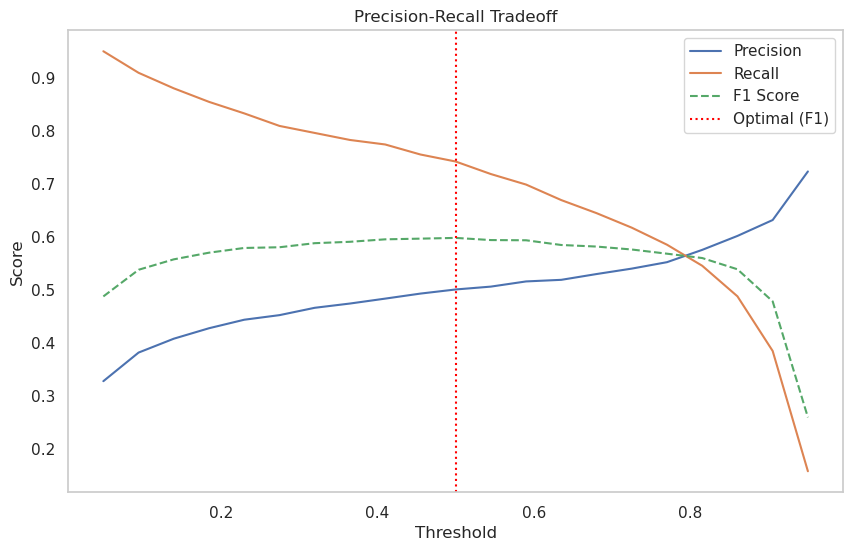

In [115]:
data_ingestion = INGESTION()
path = '../artifacts/raw.csv'
train, test = data_ingestion.ingestion(path)

data_transformation = TRANSFORMATION()
train_arr, test_arr = data_transformation.transformation(train, test)

model_trainer = MODEL_TRAINER()
model, X_test, y_test = model_trainer.trainer(train_arr, test_arr)

evaluate = EVALUATE()
resultant_df =  evaluate.threshold_calculator(model,X_test, y_test)

evaluated_values = evaluate.decor(resultant_df)

plotting = evaluate.plotting_the_curve(resultant_df)

In [ ]:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)
    threshold  precision    recall        f1
0       0.050   0.280548  0.967864  0.435004
1       0.095   0.323047  0.949905  0.482130
2       0.140   0.351178  0.930057  0.509845
3       0.185   0.374613  0.914934  0.531576
4       0.230   0.395242  0.895085  0.548350
5       0.275   0.409375  0.866730  0.556095
6       0.320   0.426597  0.845936  0.567174
7       0.365   0.441955  0.820416  0.574454
8       0.410   0.457995  0.798677  0.582156
9       0.455   0.475694  0.776938  0.590093
10      0.500   0.486486  0.748582  0.589724
11      0.545   0.499669  0.713611  0.587777
12      0.590   0.514039  0.674858  0.583572
13      0.635   0.526856  0.630435  0.574010
14      0.680   0.549421  0.583176  0.565796
15      0.725   0.567031  0.539698  0.553027
16      0.770   0.594655  0.504726  0.546012
17      0.815   0.613208  0.430057  0.505556
18      0.860   0.641892  0.359168  0.460606
19      0.905   0.679790  0.244802  0.359972
20      0.950   0.729730  0.127599  0.217216
Best threshold: 0.45499999999999996
Best Precision: 0.4756944444444444
Best recall: 0.776937618147448
Best f1: 0.5900933237616655



RandomForestClassifier(n_estimators=200, random_state=42)
    threshold  precision    recall        f1
0       0.050   0.227362  0.989603  0.369769
1       0.095   0.278345  0.979206  0.433473
2       0.140   0.315708  0.965028  0.475769
3       0.185   0.341389  0.948015  0.502002
4       0.230   0.369516  0.923440  0.527823
5       0.275   0.389963  0.896030  0.543422
6       0.320   0.413024  0.875236  0.561212
7       0.365   0.430159  0.841210  0.569236
8       0.410   0.450959  0.799622  0.576687
9       0.455   0.474646  0.760870  0.584604
10      0.500   0.493498  0.717391  0.584746
11      0.545   0.520000  0.675803  0.587752
12      0.590   0.547280  0.618147  0.580559
13      0.635   0.567829  0.553875  0.560766
14      0.680   0.585118  0.490548  0.533676
15      0.725   0.606019  0.418715  0.495249
16      0.770   0.620339  0.345936  0.444175
17      0.815   0.658879  0.266541  0.379542
18      0.860   0.700637  0.207940  0.320700
19      0.905   0.710526  0.127599  0.216346
20      0.950   0.727273  0.060491  0.111693
Best threshold: 0.545
Best Precision: 0.52
Best recall: 0.6758034026465028
Best f1: 0.5877517468146322





SyntaxError: positional argument follows keyword argument (1850930272.py, line 12)